In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
epochs = 200
batch_size = 64
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 3
seed = random.randint(1, 1000)
target_names=['Caterpillar','Diabrotica speciosa','Healthy']

data_dir = "../input/soybean-disease-dataset/train/"
data_dir1 = "../input/soybean-disease-dataset/test/"

In [3]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)
val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

test_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed
)

Found 4618 images belonging to 3 classes.
Found 1153 images belonging to 3 classes.
Found 639 images belonging to 3 classes.


../input/soybean-disease-dataset/train/Caterpillar/caterpillar (1912).jpg


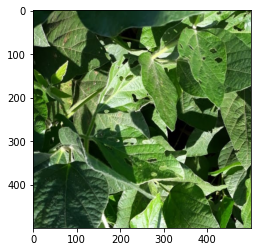

In [4]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [5]:
checkpoint = ModelCheckpoint('DenseNet201.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

2022-10-31 06:13:36.249684: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 06:13:36.249733: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-31 06:13:36.363087: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-10-31 06:13:36.583489: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-31 06:13:36.583655: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [6]:
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

2022-10-31 06:13:36.664001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:13:36.665154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:13:36.980254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:13:36.981185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 06:13:36.981962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

74850304/74836368 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

In [7]:
%%time

model_history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Beginning training
Epoch 1/200
Learning rate:  1e-04


2022-10-31 06:13:49.644730: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-31 06:14:11.979045: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-10-31 06:14:26.101024: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-31 06:14:26.101154: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-31 06:14:29.426909: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying t

 1/73 [..............................] - ETA: 53:43 - loss: 1.3689 - accuracy: 0.3906

2022-10-31 06:14:34.475836: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-31 06:14:34.476191: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/73 [..............................] - ETA: 2:15 - loss: 1.2853 - accuracy: 0.4141 

2022-10-31 06:14:36.395532: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-31 06:14:36.401875: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-10-31 06:14:36.682533: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 4915 callback api events and 4912 activity events. 
2022-10-31 06:14:36.908727: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-31 06:14:37.174465: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs-10312022061336/train/plugins/profile/2022_10_31_06_14_36

2022-10-31 06:14:37.304977: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs-10312022061336/train/plugins/profile/2022_10_31_06_14_36/246e33883d3b.trace.json.gz
2022-10-31 06:14:37.620328: I tensorflow/core/profiler/rpc/client/save_profile.cc:136]

45/73 [=================>............] - ETA: 53s - loss: 0.5775 - accuracy: 0.7997

2022-10-31 06:16:00.697745: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-31 06:16:00.698481: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-31 06:16:02.161505: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-10-31 06:16:02.161630: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc

73/73 [==============================] - 221s 2s/step - loss: 0.4879 - accuracy: 0.8322 - val_loss: 0.8063 - val_accuracy: 0.6349
End of epoch 0. Learning rate: 1e-04

Epoch 00001: val_accuracy improved from -inf to 0.63487, saving model to DenseNet201.h5
Epoch 2/200
Learning rate:  1e-04
73/73 [==============================] - 148s 2s/step - loss: 0.1754 - accuracy: 0.9476 - val_loss: 0.7005 - val_accuracy: 0.7598
End of epoch 1. Learning rate: 1e-04

Epoch 00002: val_accuracy improved from 0.63487 to 0.75976, saving model to DenseNet201.h5
Epoch 3/200
Learning rate:  1e-04
73/73 [==============================] - 150s 2s/step - loss: 0.1147 - accuracy: 0.9617 - val_loss: 0.7988 - val_accuracy: 0.7589
End of epoch 2. Learning rate: 1e-04

Epoch 00003: val_accuracy did not improve from 0.75976
Epoch 4/200
Learning rate:  1e-04
73/73 [==============================] - 148s 2s/step - loss: 0.0721 - accuracy: 0.9773 - val_loss: 0.7709 - val_accuracy: 0.8291
End of epoch 3. Learning rate:

In [8]:
history = pd.DataFrame(model_history.history)
history.to_csv('DenseNet201.csv', index=False)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,0.487934,0.832178,0.806261,0.634866,0.000100
1,0.175353,0.947596,0.700514,0.759757,0.000100
2,0.114662,0.961672,0.798828,0.758890,0.000100
3,0.072129,0.977263,0.770902,0.829141,0.000100
4,0.042593,0.987224,0.901242,0.794449,0.000100
5,0.031550,0.989822,1.007850,0.803122,0.000100
6,0.029091,0.990256,0.620844,0.862966,0.000100
7,0.059135,0.980295,0.920262,0.816132,0.000100
8,0.053144,0.982243,0.665360,0.838682,0.000100
9,0.023821,0.991771,1.043918,0.817866,0.000100


<h2>Plotting<h2>

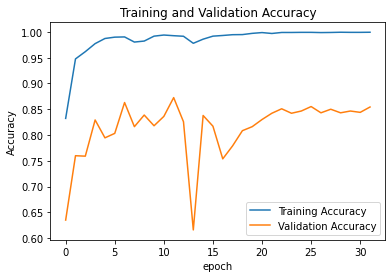

In [9]:
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

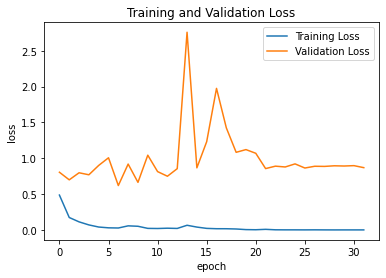

In [10]:
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

<h2>Model Evaluation<h2>

In [11]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
                     precision    recall  f1-score   support

        Caterpillar       0.94      0.95      0.95       330
Diabrotica speciosa       0.94      0.92      0.93       220
            Healthy       0.90      0.88      0.89        89

           accuracy                           0.93       639
          macro avg       0.92      0.92      0.92       639
       weighted avg       0.93      0.93      0.93       639



In [12]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.OrRd):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Normalized confusion matrix


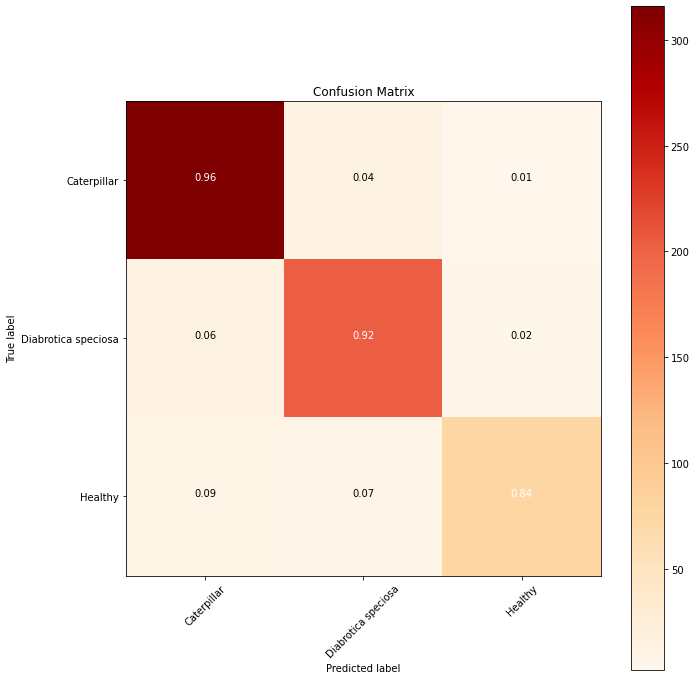

In [13]:
#Confution Matrix 
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

category =target_names
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, category, title='Confusion Matrix')

In [14]:
model.evaluate(test_generator , verbose = 0)

[0.35505443811416626, 0.934272289276123]

1


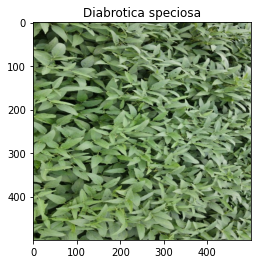

In [15]:
#Test the model
model = load_model('./DenseNet201.h5')

test_image='../input/soybean-disease-dataset/test/Diabrotica speciosa/diabroticaspeciosa (1010).jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(targetx, targety))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)

result=model.predict(test_image)
print(np.argmax(result))
Categories =target_names
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()

In [27]:
# #Test the model
# model = load_model('./DenseNet201.h5')

# for i in range (0,10):
#     print(f"Image No: {i}")
    
#     test_image=test_generator.filepaths[np.random.random_integers(low=0, high=test_generator.samples)]
#     print(test_image)
#     image_result=Image.open(test_image)


#     from tensorflow.keras.preprocessing import image
#     test_image=image.load_img(test_image,target_size=(targetx, targety))
#     test_image=image.img_to_array(test_image)
#     test_image=test_image/255
#     test_image=np.expand_dims(test_image,axis=0)

#     result=model.predict(test_image)
#     print(np.argmax(result))
#     Categories =target_names
#     image_result=plt.imshow(image_result)
#     plt.title(Categories[np.argmax(result)])
#     plt.show()